In [36]:
#!/usr/bin/python
import numpy as np
import scipy.sparse
import pickle
import xgboost as xgb
import csv
from collections import defaultdict
import redis
import json
import time
import sklearn.utils
### simple example
# load file from text file, also binary buffer generated by xgboost
# dtrain = xgb.DMatrix('./demo/rank_aida/mq2008.train')

# dtest = xgb.DMatrix('./demo/rank_aida/mq2008.test')

In [37]:
conn = redis.Redis(password='unswkg', host='43.240.97.73', port=8379, decode_responses=True)

def get_feature_results(exp_id, d_t, data_source='aida_conll'):
    fea_res = conn.lrange('result:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t), 0, -1)
    fea_vecs = [json.loads(res) for res in fea_res]
    return fea_vecs

In [38]:
def get_dataset_info(exp_id, d_t, data_source='aida_conll', can_size=50):
    valid_mens_size = conn.scard('valid_qry_ids:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    no_g_can_info_size = conn.scard('no_g_candidate_info:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    missed_g_candidate_size = conn.scard('missed_g_candidate:::::' + str(exp_id) + ':::::' + data_source + 
                                         ':::::' + str(d_t) + ':::::' + str(can_size))
    no_candidate_size = conn.scard('no_candidate:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    return valid_mens_size, no_candidate_size, no_g_can_info_size, missed_g_candidate_size

In [39]:
def fetch_all_features(exp_id, data_type, data_source='aida_conll'):
    res_feas = get_feature_results(exp_id, data_type, data_source)
    print(res_feas[:5])
    res_feas_ids = [[res[0].strip('(').split(', ')[0]] + res[1:] for res in res_feas]
    print(res_feas_ids[:5])
    res_feas_ids = np.array(res_feas_ids, dtype=np.float64)
    return res_feas_ids

In [40]:
def trans_data(data):
    d_np = data[:, 1:-1]
    print(d_np)
    d_labels = data[:, -1]
    print(d_labels)
    idxs = np.where(d_labels == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_labels)) - idxs
    print(d_groups)
    xgb_data = xgb.DMatrix(data=d_np, label=d_labels)
    xgb_data.set_group(d_groups)
    return xgb_data

In [41]:
def evalerror(preds, dt, d_tal_size):
    d_l = dt.get_label()
    idxs = np.where(d_l == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_l)) - idxs
    matched_ids = []
    q_id = 0
    for x in d_groups:
        pre_res = preds[q_id: x + q_id]
        if(preds[q_id] == max(pre_res)):
            if len([x for x in pre_res if x == preds[q_id]]) == 1:
                matched_ids.append(q_id)
        q_id += x
    precision = float(len(matched_ids)) / len(d_groups)
    recall = float(len(matched_ids)) / d_tal_size
    f1 = 2 * precision * recall / (precision + recall)
    return len(matched_ids), precision, recall, f1

In [42]:
from collections import defaultdict
def evalerror_detail_log(preds, dt, d_tal_size):
    d_l = dt.get_label()
    idxs = np.where(d_l == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_l)) - idxs
    correct_results = {}
    wrong_results = {}
    duplicates_results = {}
    group_info = {}
    matched_ids = []
    q_id = 0
    for x in d_groups:
        pre_res = preds[q_id: x + q_id]
        if(preds[q_id] == max(pre_res)):
            correct_results[q_id] = pre_res
            if len([x for x in pre_res if x == preds[q_id]]) == 1:
                matched_ids.append(q_id)
            else:
                duplicates_results[q_id] = pre_res
        else:
            wrong_results[q_id] = pre_res
        q_id += x
    precision = float(len(matched_ids)) / len(d_groups)
    recall = float(len(matched_ids)) / d_tal_size
    f1 = 2 * precision * recall / (precision + recall)
    return len(matched_ids), precision, recall, f1, correct_results, wrong_results, duplicates_results

In [48]:
valid_mens_size, no_candidate_size, no_g_can_info_size, missed_g_candidate_size = get_dataset_info('basic_feature_phrases_tf_idf_entropy_reduced_fea', 'test', 'wiki_uiuc')

In [49]:
dict_filename = './wiki_uiuc_training_doc_id_men_id.csv'

In [50]:
doc_men_dict = read_doc_men_dict_file(dict_filename)
doc_fea_vecs_dict = build_doc_fea_vecs_dict(d_train, doc_men_dict)

408.1616179943085


NameError: name 'doc_ids_list' is not defined

In [59]:
d_train_resample, d_test_resample = data_sampling_boostrapping(d_train, doc_men_dict, doc_fea_vecs_dict)

9938
Distinct training doc size 6295...
Constructing training mentions...
Finished Constructing training mentions, time cost 0.13133621215820312...
Distinct testing doc size 3643...
Finished Constructing testing mentions, time cost 0.023510217666625977...


In [63]:
dtrain = trans_data(d_train_resample)
dtest = trans_data(d_test_resample)
# print(dtrain_g)
# print(dtest_g)

[[  4.34889436e-01   8.00000000e+00   4.34889436e-01 ...,   7.06169561e-04
    8.95117505e-03   8.45491765e-02]
 [  2.87469298e-01   8.00000000e+00   4.34889436e-01 ...,   1.66394036e-03
    1.30014895e-02   1.06551622e-01]
 [  1.03194103e-01   8.00000000e+00   4.34889436e-01 ...,   5.80435908e-03
    3.69313494e-02   1.53816297e-01]
 ..., 
 [  9.97191012e-01   2.00000000e+00   9.97191012e-01 ...,   2.13496451e-03
    1.06748225e-02   6.26477541e-02]
 [  2.80898879e-03   2.00000000e+00   9.97191012e-01 ...,   1.17589842e-03
    1.17589842e-03   3.90625000e-02]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[ 1.  0.  0. ...,  1.  0.  1.]
[8 1 2 ..., 1 2 1]
[[  9.44444418e-01   2.00000000e+00   9.44444418e-01 ...,   2.57422606e-03
    2.00789633e-02   1.86762442e-01]
 [  5.55555560e-02   2.00000000e+00   9.44444418e-01 ...,   9.49621437e-04
    2.37405359e-03   6.94006309e-02]
 [  1.00000000e+00   1.00000000e+00   1.000000

In [29]:
n_estimators = range(4500, 5000, 200)
max_depth = [4, 6]

In [20]:
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        bst = xgb.train(param, dtrain, num_round)
        preds = bst.predict(dtrain)
        a = evalerror(preds, dtrain, 18541)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[0], a[1]))
        preds = bst.predict(dtest)
        a = evalerror(preds, dtest, 4485)
        print("n_estimators: {}, max_depth: {}, acc_testing: {}, corr_num: {}".format(num_round, dep, a[0], a[1]))
        print("---------------------------------")

n_estimators: 100, max_depth: 4, acc_training: 0.7711558168383582, corr_num: 14298
n_estimators: 100, max_depth: 4, acc_testing: 0.7163879598662207, corr_num: 3213
---------------------------------
n_estimators: 100, max_depth: 6, acc_training: 0.8203441022598565, corr_num: 15210
n_estimators: 100, max_depth: 6, acc_testing: 0.7868450390189521, corr_num: 3529
---------------------------------
n_estimators: 100, max_depth: 8, acc_training: 0.879564209050213, corr_num: 16308
n_estimators: 100, max_depth: 8, acc_testing: 0.8133779264214047, corr_num: 3648
---------------------------------
n_estimators: 100, max_depth: 10, acc_training: 0.9209859230893696, corr_num: 17076
n_estimators: 100, max_depth: 10, acc_testing: 0.8251950947603122, corr_num: 3701
---------------------------------
n_estimators: 500, max_depth: 4, acc_training: 0.8502238282724772, corr_num: 15764
n_estimators: 500, max_depth: 4, acc_testing: 0.8013377926421404, corr_num: 3594
---------------------------------
n_estimat

In [12]:
num_round=4900
param = {'max_depth':6, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
model = xgb.train(param, dtrain, num_round)

NameError: name 'dtrain' is not defined

In [43]:
d_train = fetch_all_features('basic_features_context_emnlp17_spacy_md_50', 'train', 'aida_conll')
d_test = fetch_all_features('basic_features_context_emnlp17_spacy_md_50', 'testa', 'aida_conll')

[["(385690, 'Komerční_banka')", 0.5, 0.5, 2, 1.0, 1, 0, 1.0, 4.5281714538981186e-09, 1.0, 1.867292391559149e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1], ["(385694, 'OKD')", 0.857142857142857, 0.857142857142857, 2, 1.0, 1, 0, 1.0, 1.9949286824865837e-09, 1.0, 5.027325669582324e-08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1], ["(380669, 'Johan_Museeuw')", 1.0, 1.0, 1, 1.0, 1, 0, 1.0, 3.207718659299856e-08, 1.0, 8.33099682387928e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1], ["(382346, 'Videoton_FC')", 0.970149253731343, 0.970149253731343, 4, 0.963784432064376, 2, 0, 0.8602150537634409, 8.106376868516912e-08, 0.9843014128728415, 4.503047421183024e-06, 42.0, 117.0, 0.0, 7.826779887263512, 25.888579627102384, 0.3010299956639812, 0.025213561245786612, 0.08759605016393343, 0.002682293749551767, 0.025213561245786612, 0.20824847250509165, 1], ["(382346, 'Videoton_(company)')", 0.0223880597014925, 0.970149253731343, 4, 0.0389933457134014, 2, 0, 

In [44]:
d_test_b = fetch_all_features('basic_features_context_emnlp17_spacy_md_50', 'testb', 'aida_conll')

[["(404783, 'Pierre_Lueders')", 1.0, 1.0, 1, 1.0, 1, 0, 1.0, 1.6212753737033823e-08, 1.0, 9.911013462890868e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1], ["(404784, 'David_MacEachern')", 1.0, 1.0, 1, 1.0, 1, 0, 1.0, 3.6415364839040814e-09, 1.0, 1.5081977008746971e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1], ["(400897, 'Italy_national_rugby_union_team')", 0.0105975574092384, 0.870503697308137, 753, 0.010218911107386, 231, 0, 0.012924793283840885, 2.490177644297539e-07, 0.0077848789774272505, 6.578614733339155e-06, 63.19259122300139, 167.504589060646, 0, 46.986321571295306, 88.46445929525724, 1.6989700043360187, 0.09759752860933199, 0.2281311958812158, 0.008157939099312308, 0.05192296721293524, 0.3371491822456053, 1], ["(400897, 'Italy')", 0.870503697308137, 0.870503697308137, 753, 0.808390766960722, 231, 0, 0.5994201593247026, 1.1548832136122688e-05, 0.7776720152298069, 0.0006571720115278014, 67.39892751143287, 163.4460274344377, 0, 46.72815563240177

In [45]:
dtest_b = trans_data(d_test_b)

[[  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.05975574e-02   8.70503697e-01   7.53000000e+02 ...,   8.15793910e-03
    5.19229672e-02   3.37149182e-01]
 ..., 
 [  1.33244504e-03   5.30313125e-01   8.00000000e+00 ...,   4.92990576e-03
    1.39971282e-02   8.18636545e-02]
 [  6.66222518e-04   5.30313125e-01   8.00000000e+00 ...,   1.06429737e-02
    6.28008029e-02   1.39086551e-01]
 [  9.91666667e-01   9.91666667e-01   2.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[ 1.  1.  1. ...,  0.  0.  1.]
[ 1  1 50 ...,  2  9  1]


In [46]:
dtrain = trans_data(d_train)
dtest = trans_data(d_test)

[[  5.00000000e-01   5.00000000e-01   2.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  8.57142857e-01   8.57142857e-01   2.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  2.54841998e-04   5.60907238e-01   1.78000000e+02 ...,   1.28159761e-03
    7.04793385e-03   2.49656569e-01]
 [  2.54841998e-04   5.60907238e-01   1.78000000e+02 ...,   2.20419718e-03
    9.74948714e-03   3.36189011e-01]
 [  0.00000000e+00   5.60907238e-01   1.78000000e+02 ...,   1.62063521e-03
    9.50137197e-03   3.06299087e-01]]
[ 1.  1.  1. ...,  0.  0.  0.]
[ 1  1  1 ..., 50 50 50]
[[  3.56031801e-01   5.89353612e-01   2.70000000e+01 ...,   7.23881938e-03
    3.06742969e-02   1.20107887e-01]
 [  5.89353612e-01   5.89353612e-01   2.70000000e+01 ...,   6.20886366e-03
    2.04155684e-02   1.66384354e-01]
 [  1.72830971e-04   5.89353612e-01   2.

In [47]:
n_estimators = range(4500, 6500, 200)
max_depth = [4, 6]
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        bst = xgb.train(param, dtrain, num_round)
        preds = bst.predict(dtrain)
        a = evalerror_detail_log(preds, dtrain, 18541)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest)
        a = evalerror_detail_log(preds, dtest, 4791)        
        print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_b)
        a = evalerror_detail_log(preds, dtest_b, 4485)
        print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        print("---------------------------------")

n_estimators: 4500, max_depth: 4, acc_training: 0.9355482444312605, corr_num: 17346
n_estimators: 4500, max_depth: 4, acc_validation: 0.8808182007931539, corr_num: 4220
n_estimators: 4500, max_depth: 4, acc_test: 0.8606465997770345, corr_num: 3860
---------------------------------
n_estimators: 4500, max_depth: 6, acc_training: 0.9692033870880751, corr_num: 17970
n_estimators: 4500, max_depth: 6, acc_validation: 0.8893759131705281, corr_num: 4261
n_estimators: 4500, max_depth: 6, acc_test: 0.861092530657748, corr_num: 3862
---------------------------------
n_estimators: 4700, max_depth: 4, acc_training: 0.9367348039480071, corr_num: 17368
n_estimators: 4700, max_depth: 4, acc_validation: 0.881235650177416, corr_num: 4222
n_estimators: 4700, max_depth: 4, acc_test: 0.8606465997770345, corr_num: 3860
---------------------------------
n_estimators: 4700, max_depth: 6, acc_training: 0.9701742085108678, corr_num: 17988
n_estimators: 4700, max_depth: 6, acc_validation: 0.8893759131705281, co

KeyboardInterrupt: 

In [17]:
model_name = './no_poly_4900_6.mdl'
with open(model_name, 'wb') as f:
    pickle.dump(model, f)
model = pickle.load(open(model_name, 'rb'))

In [17]:
d_train[4]

array([  3.88430000e+05,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.70487239e-07,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00])

In [288]:
preds = model.predict(dtrain)
a = evalerror_detail_log(preds, dtrain, 18541)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))
preds = model.predict(dtest)
a = evalerror_detail_log(preds, dtest, 4485)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))
print("---------------------------------")

correct_num: 18066, precision: 0.9830766719268651, recall: 0.9743811013429696, f1: 0.9787095725662279
correct_num: 4286, precision: 0.9065143824027073, recall: 0.9556298773690078, f1: 0.9304244003039185
---------------------------------


In [302]:
preds = model.predict(dtrain)
a = evalerror_detail_log(preds, dtrain, 18541)

In [303]:
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 18066, precision: 0.9830766719268651, recall: 0.9743811013429696, f1: 0.9787095725662279


In [18]:
preds = model.predict(dtest)
a = evalerror_detail_log(preds, dtest, 4791)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767


In [19]:
correct_results, wrong_results, duplicates_results = a[4:]

In [103]:
a = defaultdict(int)
for key, val in correct_results.items():
    if len(val) > 1:
        sec_min_val, max_val = np.partition(val.flatten(), -2)[-2:]
        a[np.around(max_val - sec_min_val)] += 1
    else:
        a[-1] += 1

In [290]:
wrong_results

{188: array([ 4.10348558,  4.70063877, -0.79406285, -2.55898905, -6.96980286,
        -3.97091198, -5.75258064, -6.8513937 , -5.94697523, -8.45194817,
        -5.35875654, -6.91054535, -8.55962753, -8.70056534, -6.62276602,
        -7.4982419 , -7.28822756, -6.01760912, -7.75263977, -7.92220211,
        -7.42139387, -9.08217716, -4.65167904, -8.94179058, -8.24415207,
        -6.05439138, -7.34835672, -6.09715033, -8.42887974, -7.74894619,
        -6.4312315 , -6.16466522, -4.91667509, -6.41882324, -6.87952709,
        -8.30599403, -9.36153126, -5.12192726, -6.0338788 , -9.04207993,
        -6.00279856, -8.72424698, -7.10032272, -9.08372879, -6.19408464,
        -4.85332203, -7.66691303, -9.55222702, -5.44673347, -6.69717741], dtype=float32),
 624: array([ 4.10348558,  4.70063877, -0.79406285, -2.55898905, -6.96980286,
        -3.97091198, -5.75258064, -6.8513937 , -5.94697523, -8.45194817,
        -5.35875654, -6.91054535, -8.55962753, -8.70056534, -6.62276602,
        -7.4982419 , -7.

In [124]:
sec_count = 0
pos_g_ent_dict = defaultdict(int)
b = defaultdict(int)
for key, val in wrong_results.items():
    if len(val) > 1:
        predicted_g_val = val[0]
        sec_min_val, max_val = np.partition(val.flatten(), -2)[-2:]
        r_sorted_arr = np.sort(val)[::-1]
#         print(val)
#         print(r_sorted_arr)
#         print(predicted_g_val)
        pos_g_ent_dict[np.where(r_sorted_arr==predicted_g_val)[0][0] + 1] += 1
        if sec_min_val == predicted_g_val:
            sec_count += 1
            b[np.round(max_val - sec_min_val)] += 1
    else:
        b[-1] += 1

In [125]:
b, sec_count, pos_g_ent_dict

(defaultdict(int,
             {0.0: 93, 1.0: 95, 2.0: 59, 3.0: 40, 4.0: 20, 5.0: 10, 6.0: 8}),
 325,
 defaultdict(int,
             {2: 325,
              3: 84,
              4: 44,
              5: 15,
              6: 9,
              7: 1,
              8: 5,
              9: 9,
              11: 3,
              12: 2,
              13: 1,
              15: 1,
              20: 1}))

In [371]:
res_feas = get_feature_results('basic_feature_phrases_tf_idf_entropy_conll_new', 'testb', 'aida_conll')

In [355]:
res_feas

[["(395654, 'Sri_Lanka_national_cricket_team')",
  0.0227188989520073,
  32,
  0.964877784252167,
  7.206481684178209e-06,
  10.49924756307128,
  24.777938469032353,
  0,
  17.146768713229203,
  49.89922429230214,
  1.505149978319906,
  0.08741947005352425,
  0.29357498929626,
  0.02212604824153842,
  0.0394150313440636,
  0.09649740397456964,
  1],
 ["(395654, 'Sri_Lanka')",
  0.964877784252167,
  32,
  0.964877784252167,
  0.00020494834935038306,
  12.92966057619957,
  23.51343789090435,
  0,
  19.379722414121602,
  49.05898116482393,
  1.505149978319906,
  0.007787789637405074,
  0.015099989295129746,
  0.0007213307937989807,
  0.003971820894444176,
  0.031669322028873216,
  0],
 ["(395654, 'Sri_Lanka_national_football_team')",
  0.00515780411660671,
  32,
  0.964877784252167,
  1.4712194441747901e-06,
  5.677369333291,
  8.666398939393087,
  0,
  6.5856105541484675,
  11.137482465307357,
  1.505149978319906,
  0.014351444719956032,
  0.03139334935623881,
  0.0067418746191679505,
  

In [80]:
a

defaultdict(int,
            {-1: 989,
             0.0: 124,
             1.0: 286,
             2.0: 276,
             3.0: 411,
             4.0: 398,
             5.0: 384,
             6.0: 407,
             7.0: 343,
             8.0: 173,
             9.0: 100,
             10.0: 38,
             11.0: 13,
             12.0: 1,
             13.0: 3})

In [112]:
b, 

defaultdict(int,
            {0.0: 93, 1.0: 95, 2.0: 59, 3.0: 40, 4.0: 20, 5.0: 10, 6.0: 8})

In [372]:
a = np.array([[1,2,3], [3,4,5]])
b = preds

In [373]:
b = [[x] for x in b]

In [374]:
b

[[8.3403406],
 [-2.0367951],
 [0.87019575],
 [-4.0096502],
 [-1.2084513],
 [-5.119803],
 [-5.6527505],
 [-3.4771006],
 [-5.9091406],
 [-3.9960427],
 [-6.9777184],
 [-6.0252542],
 [-5.6717815],
 [-6.8747458],
 [-8.3047571],
 [0.26289022],
 [-5.4687963],
 [-2.243686],
 [-7.9186459],
 [-7.871521],
 [-5.7129903],
 [-7.0651774],
 [-0.11675292],
 [-1.0052809],
 [-4.8652101],
 [-6.4481878],
 [-5.5463562],
 [-7.1018167],
 [-5.6778665],
 [-3.5015726],
 [-7.5780916],
 [-6.1125045],
 [-7.0179949],
 [-5.4821668],
 [-6.3037906],
 [-6.4729524],
 [-5.9393868],
 [-7.7751322],
 [-6.4271073],
 [-7.8773184],
 [-6.7167759],
 [-6.500988],
 [-8.8515263],
 [-6.3874879],
 [-6.9963684],
 [-4.7833195],
 [-6.9871187],
 [-5.9293084],
 [-5.1909647],
 [-1.2484252],
 [-2.7460456],
 [-2.7780952],
 [-2.7460456],
 [8.3403406],
 [-2.0367951],
 [0.87019575],
 [-4.0096502],
 [-1.2084513],
 [-5.119803],
 [-5.6527505],
 [-3.4771006],
 [-5.9091406],
 [-3.9960427],
 [-6.9777184],
 [-6.0252542],
 [-5.6717815],
 [-6.8747458],
 

In [375]:
res = np.append(res_feas, b, axis=1)

In [218]:
def get_men_ents_tokens_idf_redis(men):
    ent_tok_dict = conn.hmget('idf:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_ents_tokens_entropy_redis(men):
    ent_tok_dict = conn.hmget('entropy:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_ents_tokens_tf_redis(men):
    ent_tok_dict = conn.hmget('tf:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_tokens_redis(data_source, doc_id):
    if data_source == 'aida_conll':
        data_source = 'conll'
    tokens = conn.hmget('men-tok-ner-spacy-' + data_source, doc_id)[0]
    return json.loads(tokens) if tokens else {}

In [115]:
import psycopg2
conn_psql = psycopg2.connect(database='zding', user='zding', password='dingzishuo', host='43.240.96.216',
                                     port=5432)

In [121]:
def fetch_mention_by_q_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT aida_conll.surfaceform, aida_conll.doc_id FROM aida_conll WHERE aida_conll.id=%s AND annotation != 'NIL';"
    cur.execute(sql % q_id)
    row = cur.fetchall()
    cur.close()
    return row

In [128]:
ss = fetch_mention_by_q_id(392222222)
print(not dict(ss))

True


In [124]:
def fetch_mention_ent_by_q_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT aida_conll.surfaceform, aida_conll.annotation, aida_conll.doc_id FROM aida_conll WHERE aida_conll.id=%s AND annotation != 'NIL';"
    cur.execute(sql % q_id)
    row = cur.fetchone()
    cur.close()
    return row

def fetch_mention_count_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT count(*) FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql , (q_id,))
    row = cur.fetchone()
    cur.close()
    return row

def fetch_ents_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT annotation FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql , (q_id,))
    row = cur.fetchall()
    cur.close()
    return row

def fetch_men_ents_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT id, annotation FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql ,(q_id,))
    row = cur.fetchall()
    cur.close()
    return row

In [340]:
def fetch_ent_cates_by_ent_id(q_id):
    q_id = 'http://en.wikipedia.org/wiki/' + q_id
    cur = conn_psql.cursor()
    sql = "SELECT labels FROM dbpedia_ontology WHERE wikipedia_url=%s;"
    cur.execute(sql, (q_id,))
    row = cur.fetchone()
    cur.close()
    return row

In [341]:
def fetch_doc_ids_by_data_type(data_type):
    cur = conn_psql.cursor()
    sql = "SELECT distinct aida_conll.doc_id FROM aida_conll WHERE aida_conll.type=\'%s\';"
    cur.execute(sql % data_type)
    rows = cur.fetchall()
    cur.close()
    return rows

In [376]:
# men, doc_id = fetch_mention_by_q_id(404048)
# ent_tok_idf = get_men_ents_tokens_idf_redis(men)
# a = get_men_tokens_redis('aida_conll', doc_id)
# fetch_mention_count_by_doc_id('1190 NFL')[0]
# b = fetch_ent_cates_by_ent_id('Indonesia_national_football_team')
# "sports team" in b[0]
doc_ids = [x[0] for x in fetch_doc_ids_by_data_type('testb')]

In [377]:
print(doc_ids)

['1229 Cricket', '1199 SOCCER', '1200 TENNIS', '1208 SOCCER', '1209 BASKETBALL', '1249 Albanian', '1271 Lebanon', '1235 Dirty', '1276 New', '1373 SOCCER', '1338 Sangetsu', '1273 USDA', '1279 Canadian', '1265 China', '1308 Delphis', '1330 NZ', '1361 ALPINE', '1359 BADMINTON', '1191 NFL', '1349 ALPINE', '1346 ALPINE', '1226 Major', '1379 CRICKET', '1196 SOCCER', '1344 ALPINE', '1303 PLO', '1306 Texas', '1289 Spain', '1241 Multinational', '1167 SOCCER', '1164 RUGBY', '1236 NYC', '1369 SOCCER', '1360 SPEED', '1215 CZECH', '1252 Estonian', '1198 SOCCER', '1370 SOCCER', '1313 Italy', '1345 ALPINE', '1315 Italian', '1205 SOCCER', '1378 CRICKET', '1227 Electronic', '1364 SOCCER', '1185 SOCCER', '1220 Tambang', '1184 BADMINTON', '1246 Five', '1307 Kansas', '1371 SOCCER', '1278 Man', '1166 FREESTYLE', '1231 Canadian', '1261 Mexican', '1333 Thai', '1170 SOCCER', '1176 SOCCER', '1284 Action', '1343 Ahold', '1353 BOBSLEIGH-SHIMER', '1380 SOCCER', '1291 German', '1390 SOCCER', '1195 SOCCER', '1194 S

In [72]:
from ast import literal_eval
import os
import re
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    if not os.path.exists(os.path.join('./tmp_result', str(q_id))):
        os.makedirs(os.path.join('./tmp_result', str(q_id)))
    men, doc_id = fetch_mention_by_q_id(q_id)
    ent_tok_idf = get_men_ents_tokens_idf_redis(men)
    ent_tok_tf = get_men_ents_tokens_tf_redis(men)
    ent_tok_entropy = get_men_ents_tokens_entropy_redis(men)
    men_toks_idx = get_men_tokens_redis('aida_conll', doc_id)
    try:
#         ent_escaped = re.sub(r'[\'\"–\/Žşáí-ţ]', '_', ent)
        with open(os.path.join('./tmp_result', str(q_id), 'mention_' + men + '.csv'), 'w', encoding='utf-8') as f:
            csv_wtr = csv.writer(f)
            csv_wtr.writerow(["token", "tf"])
            for tok, idxs in men_toks_idx.items():
                 csv_wtr.writerow([tok, len(idxs)])
    except:
        print(men)
    for ent, tok_idfs in ent_tok_idf.items():
        try:
            ent_escaped = re.sub(r'[\'\"–\/Žşáí-ţ]', '_', ent)
            with open(os.path.join('./tmp_result', str(q_id), ent_escaped + '.csv'), 'w', encoding='utf-8') as f:
                csv_wtr = csv.writer(f)
                csv_wtr.writerow(["token", "tf", "idf", "entropy"])
                for tok, idf in tok_idfs.items():
                     csv_wtr.writerow([tok, ent_tok_tf[ent][tok], idf, ent_tok_entropy[ent][tok]])
        except:
            print(ent)
#     break
#     print(literal_eval(res[key][0])[0])

In [110]:
from ast import literal_eval
import os
import re
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    if not os.path.exists(os.path.join('./tmp_result', str(q_id))):
        os.makedirs(os.path.join('./tmp_result', str(q_id)))
    men, doc_id = fetch_mention_by_q_id(q_id)
    ent_tok_idf = get_men_ents_tokens_idf_redis(men)
    ent_tok_tf = get_men_ents_tokens_tf_redis(men)
    ent_tok_entropy = get_men_ents_tokens_entropy_redis(men)
    men_toks_idx = get_men_tokens_redis('aida_conll', doc_id)
#     print(men_toks_idx)
    try:
        with open(os.path.join('./tmp_result', str(q_id), 'men_ent_common_toks.csv'), 'w', encoding='utf-8') as f:
            csv_wtr = csv.writer(f)
            csv_wtr.writerow(["token"] + list(ent_tok_idf.keys()))
#             print(men_toks_idx.items())
            for tok, idxs in men_toks_idx.items():
                csv_wtr.writerow([tok] + [' '.join([str(ent_tok_tf[ent].get(tok, ''))[:6], str(ent_tok_idf[ent].get(tok, ''))[:5], str(ent_tok_entropy[ent].get(tok,''))[:5]]) for ent in ent_tok_idf.keys()])
    except:
        print(men)

In [98]:
ent_tok_idf

{'John_Bower_Lewis': {"'s": 0.1945746647496944,
  '1817': 1.5563025007672873,
  '1820': 1.5563025007672873,
  '1839': 1.5563025007672873,
  '1847': 1.0791812460476249,
  '1848': 1.255272505103306,
  '1854': 0.9542425094393249,
  '1855 to 1857': 1.5563025007672873,
  '1863': 1.255272505103306,
  '1867': 1.255272505103306,
  '1872': 1.255272505103306,
  '1873': 1.255272505103306,
  '1874': 1.0791812460476249,
  '24': 0.9542425094393249,
  'admit': 0.9542425094393249,
  'bar': 0.9542425094393249,
  'bear': 0.1413291527964693,
  'bytown': 1.5563025007672873,
  'campaign': 0.8573324964312685,
  'canada': 1.0791812460476249,
  'canadian': 1.0791812460476249,
  'city': 0.7781512503836436,
  'come': 0.8573324964312685,
  'commissioner': 1.255272505103306,
  'council': 1.0791812460476249,
  'counsel': 1.5563025007672873,
  'death': 0.6020599913279624,
  'die': 0.3521825181113625,
  'elect': 0.6020599913279624,
  'family': 0.6020599913279624,
  'first': 0.3010299956639812,
  'france': 1.07918124

In [140]:
import csv

In [195]:
with open("correct_features_score.csv", 'w', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    for key, val in correct_results.items():
        csv_writer.writerows(res[key: key+len(val)])

In [151]:
with open("wrong_features_score.csv", 'a', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    for key, val in wrong_results.items():
        csv_writer.writerows(res[key: key+len(val)])
#         csv_writer.writerow(ress)
#     csv_writer.writerows(res)


In [ ]:
correct_results

In [126]:
from xgboost import plot_importance
from matplotlib import pyplot

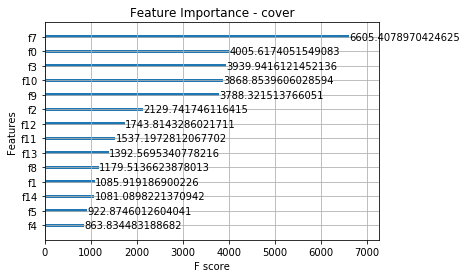

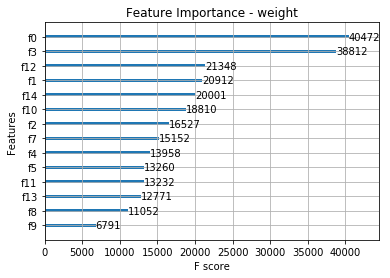

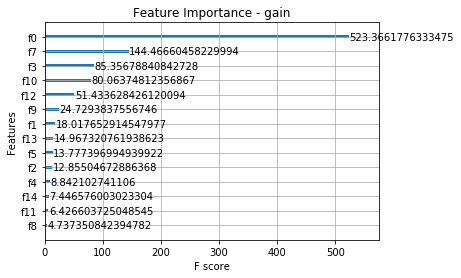

In [135]:
plot_importance(model, importance_type='cover', title='Feature Importance - cover')
pyplot.show()
plot_importance(model, importance_type='weight', title='Feature Importance - weight')
pyplot.show()
plot_importance(model, importance_type='gain', title='Feature Importance - gain')
pyplot.show()

In [2]:
import pickle
from xgboost import plot_tree
model_name = './no_poly_4900_6.mdl'
# with open(model_name, 'wb') as f:
#     pickle.dump(model, f)
model = pickle.load(open(model_name, 'rb'))
# plot_tree(model, num_trees=0)

In [3]:
from xgboost import plot_importance
from matplotlib import pyplot
from graphviz import Digraph

In [5]:
# from xgboost import plot_tree
# import matplotlib.pyplot as plt
from matplotlib import pyplot
# import pydot
# plt.figure(figsize=(20,15))
# xgb.plot_tree(model)
# plt.show()
# from matplotlib.pylab import rcParams
# xgb.plot_tree(model, num_trees=2)
##set up the parameters
# rcParams['figure.figsize'] = 10,5
# xgb.to_graphviz(model, num_trees=0)
plot_tree(model)
pyplot.show()
# xgb.to_graphviz(model, num_trees=0, rankdir='LR')

Format: "png" not recognized. Use one of: canon cmap cmapx cmapx_np dot dot_json eps fig gv imap imap_np ismap json json0 mp pic plain plain-ext pov ps ps2 svg svgz tk vml vmlz xdot xdot1.2 xdot1.4 xdot_json


CalledProcessError: Command '['dot', '-Tpng']' returned non-zero exit status 1.

In [7]:
model.para

AttributeError: 'Booster' object has no attribute '_Booster'

In [77]:
a = [1, 2, 3]

[y for z in [[str(x) + 'a', str(x) + 'b'] for x in a] for y in z]

['1a', '1b', '2a', '2b', '3a', '3b']

In [87]:
for key, val in a.items():
    print(key)

say
john lewis partnership
4.5 percent
11.4 percent
- year
total
include
rosemary bennett
2774
the 18 week
waitrose
13.6 percent
rise
department
18-week
period
542
week
london 1996 - 12 - 06
sale
november 30
the week to november 30
supermarket
44 171
compare
john lewis uk
uk
london
store
year
the week
5.8 percent
the same week a year earlier
newsroom
chain
4.5 %


In [114]:
a = np.array([1,2,3,4])

In [119]:
np.where(a==1)[0][0]

0

In [130]:
model.get_split_value_histogram('f7')

,SplitValue,Count
0,0.043112,21.0
1,0.081837,3.0
2,0.120563,2.0
3,0.159288,1.0
4,0.198013,43.0
5,0.236738,4.0
6,0.275464,13.0
7,0.314189,14.0
8,0.352914,18.0
9,0.391639,14.0


In [378]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_err_ids_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)
doc_teams_all_dict = defaultdict(list)
doc_teams_errors_dict = defaultdict(list)
doc_men_ent_dict = defaultdict(dict)

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    
    q_id = literal_eval(res[key][0])[0]
    predicted_g_val = val[0]
    r_sorted_arr = np.sort(val)[::-1]
    g_ent_rank = np.where(r_sorted_arr==predicted_g_val)[0][0] + 1
#     men, doc_id = fetch_mention_by_q_id(q_id)
    men, g_ent, doc_id = fetch_mention_ent_by_q_id(q_id)
    
    if doc_id not in doc_men_ent_dict:
        for x in doc_ids:
            doc_men_ent_dict[x] = dict(fetch_men_ents_by_doc_id(x))
            for men_id, ent in doc_men_ent_dict[x].items():
                ent_labels = fetch_ent_cates_by_ent_id(escape_entity(ent))
                if ent_labels and "sports team" in ent_labels[0]:
                    doc_teams_all_dict[x].append(men_id)
    
    if doc_id not in doc_men_cnt_dict:
        doc_men_cnt_dict[doc_id] = fetch_mention_count_by_doc_id(doc_id)[0]
    
    
    pred_ent = literal_eval(res[key+np.argmax(val)][0])[1]
    
    doc_err_ids_dict[doc_id].append(q_id)
    
    if q_id in doc_teams_all_dict[doc_id]:
        doc_teams_errors_dict[doc_id].append(q_id)
        
    doc_err_dict[doc_id].append(str(q_id)+ ': ' + men + '->' + escape_entity(g_ent) + '->' + str(g_ent_rank) + '->' + escape_entity(pred_ent))
    if men.isupper():
        print(men, doc_id)

JAPAN 1163 SOCCER
CHINA 1163 SOCCER
OAKLAND 1239 Russ
BOSTON 1385 NHL
BUFFALO 1385 NHL
WASHINGTON 1385 NHL
CHICAGO 1385 NHL
LPGA 1347 GOLF
MONTREAL 1385 NHL
TORONTO 1385 NHL
VANCOUVER 1186 NHL
PITTSBURGH 1385 NHL
MELBOURNE 1179 CRICKET
BUFFALO 1186 NHL
MONTREAL 1186 NHL
AUSTRALIA 1180 CRICKET
EDS 1227 Electronic
CHICAGO 1186 NHL
CUTTITTA 1164 RUGBY
FSA 1274 BALANCE
PHILADELPHIA 1186 NHL
ITALY 1164 RUGBY
DALLAS 1186 NHL
HOBART 1181 CRICKET
RTRS 1331 RTRS
OTTAWA 1186 NHL
CHICAGO 1386 NHL
ATLANTIC 1383 NBA
NLD 1267 Burmese
NLD 1267 Burmese
NEW YORK 1383 NBA
BOSTON 1187 NHL
PHILADELPHIA 1383 NBA
NORTHERN IRELAND 1364 SOCCER
NEW JERSEY 1383 NBA
JAPAN 1165 SOCCER
LEEDS 1171 SOCCER
CENTRAL DIVISION 1383 NBA
SYRIA 1165 SOCCER
CHICAGO 1383 NBA
AUSTRALIA 1375 RUGBY
DETROIT 1383 NBA
BARBARIANS 1375 RUGBY
LOS ANGELES 1187 NHL
CLEVELAND 1383 NBA
ATLANTA 1383 NBA
INDIANA 1383 NBA
INDIANAPOLIS 1188 NFL
EUROLEAGUE 1172 BASKETBALL
WORLD CUP 1205 SOCCER
HOUSTON 1383 NBA
MINNESOTA 1383 NBA
NEW YORK 1232 

In [259]:
doc_teams_errors_dict

defaultdict(list,
            {'1163 SOCCER': [400495,
              400500,
              400502,
              400514,
              400515,
              400520,
              400524,
              400525,
              400529,
              400539],
             '1164 RUGBY': [400542,
              400544,
              400546,
              400550,
              400555,
              400558,
              400559],
             '1165 SOCCER': [400584,
              400585,
              400588,
              400590,
              400593,
              400596,
              400600,
              400601,
              400607,
              400610,
              400624],
             '1167 SOCCER': [400686, 400688, 400698],
             '1169 SOCCER': [400778],
             '1170 SOCCER': [400782],
             '1172 BASKETBALL': [400823,
              400841,
              400849,
              400851,
              400853,
              400863],
             '1173 RUGBY': [400934,
 

In [192]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    
    q_id = literal_eval(res[key][0])[0]
    predicted_g_val = val[0]
#     sec_min_val, max_val = np.partition(val.flatten(), -2)[-2:]
    r_sorted_arr = np.sort(val)[::-1]
    g_ent_rank = np.where(r_sorted_arr==predicted_g_val)[0][0] + 1
#     res[key+len(val)]
    men, doc_id = fetch_mention_by_q_id(q_id)
    if doc_id not in doc_men_cnt_dict:
        doc_men_cnt_dict[doc_id] = fetch_mention_count_by_doc_id(doc_id)[0]
    men, ent, doc_id = fetch_mention_ent_by_q_id(q_id)
    pred_ent = literal_eval(res[key+np.argmax(val)][0])[1]
    doc_err_dict[doc_id].append(str(q_id)+ ': ' + men + '->' + escape_entity(ent) + '->' + str(g_ent_rank) + '->' + escape_entity(pred_ent))
    if men.isupper():
        print(men, doc_id)

JAPAN 1163 SOCCER
CHINA 1163 SOCCER
OAKLAND 1239 Russ
BOSTON 1385 NHL
BUFFALO 1385 NHL
WASHINGTON 1385 NHL
CHICAGO 1385 NHL
LPGA 1347 GOLF
MONTREAL 1385 NHL
TORONTO 1385 NHL
VANCOUVER 1186 NHL
PITTSBURGH 1385 NHL
MELBOURNE 1179 CRICKET
BUFFALO 1186 NHL
MONTREAL 1186 NHL
AUSTRALIA 1180 CRICKET
EDS 1227 Electronic
CHICAGO 1186 NHL
CUTTITTA 1164 RUGBY
FSA 1274 BALANCE
PHILADELPHIA 1186 NHL
ITALY 1164 RUGBY
DALLAS 1186 NHL
HOBART 1181 CRICKET
RTRS 1331 RTRS
OTTAWA 1186 NHL
CHICAGO 1386 NHL
ATLANTIC 1383 NBA
NLD 1267 Burmese
NLD 1267 Burmese
NEW YORK 1383 NBA
BOSTON 1187 NHL
PHILADELPHIA 1383 NBA
NORTHERN IRELAND 1364 SOCCER
NEW JERSEY 1383 NBA
JAPAN 1165 SOCCER
LEEDS 1171 SOCCER
CENTRAL DIVISION 1383 NBA
SYRIA 1165 SOCCER
CHICAGO 1383 NBA
AUSTRALIA 1375 RUGBY
DETROIT 1383 NBA
BARBARIANS 1375 RUGBY
LOS ANGELES 1187 NHL
CLEVELAND 1383 NBA
ATLANTA 1383 NBA
INDIANA 1383 NBA
INDIANAPOLIS 1188 NFL
EUROLEAGUE 1172 BASKETBALL
WORLD CUP 1205 SOCCER
HOUSTON 1383 NBA
MINNESOTA 1383 NBA
NEW YORK 1232 

In [379]:
total_sports = 0
total_err_sports = 0
total_correct_sports = 0
for doc_id, mens in doc_err_dict.items():
    print('Doc ID: ' + doc_id)
    print('Total errors: ' + str(len(mens)) + '    total mentions: ' + str(doc_men_cnt_dict[doc_id]))
    total_sports += len(doc_teams_all_dict[doc_id])
    total_err_sports += len(doc_teams_errors_dict[doc_id])
    print('Total errors (sports teams): ' + str(len(doc_teams_errors_dict[doc_id])) + '    total mentions (sports teams):' + str(len(doc_teams_all_dict[doc_id])))
    print('All Errors mentions:\n{}'.format('\n'.join(mens)))
    print('Correct Mentions (sports teams):')
    correct_teams = [x for x in doc_teams_all_dict[doc_id] if x not in doc_teams_errors_dict[doc_id]]
    for q_id in correct_teams:
        total_correct_sports +=1
        men, ent, doc_id = fetch_mention_ent_by_q_id(q_id)
        print(str(q_id) + ": " + men + '->' + escape_entity(ent))
    print('\n')

Doc ID: 1324 John
Total errors: 1    total mentions: 3
Total errors (sports teams): 0    total mentions (sports teams):0
All Errors mentions:
404048: John Lewis->John_Lewis_Partnership->2->John_Lewis_(department_store)
Correct Mentions (sports teams):


Doc ID: 1297 London
Total errors: 4    total mentions: 13
Total errors (sports teams): 0    total mentions (sports teams):0
All Errors mentions:
403630: China Steel->China_Steel->2->Chinese_Taipei_national_under-23_football_team
403633: Fos->Fos-sur-Mer->2->Marseille
403637: China Steel->China_Steel->2->Chinese_Taipei_national_under-23_football_team
403628: Newcastle->Newcastle_upon_Tyne->2->Newcastle,_New_South_Wales
Correct Mentions (sports teams):


Doc ID: 1356 CRICKET
Total errors: 14    total mentions: 30
Total errors (sports teams): 0    total mentions (sports teams):0
All Errors mentions:
404885: Woolmer->Clarence_Woolmer->2->Bob_Woolmer
404887: Woolmer->Clarence_Woolmer->2->Bob_Woolmer
404888: Kanpur->Kanpur->2->Green_Park_Stad

In [380]:
total_sports = 0
# total_err_sports = 0
# total_correct_sports = 0
for x, y in doc_teams_all_dict.items():
    total_sports += len(y)
    print(x)
#     doc_teams_all_dict[x].append(men_id)

1199 SOCCER
1208 SOCCER
1209 BASKETBALL
1373 SOCCER
1191 NFL
1196 SOCCER
1167 SOCCER
1164 RUGBY
1369 SOCCER
1198 SOCCER
1370 SOCCER
1205 SOCCER
1364 SOCCER
1371 SOCCER
1170 SOCCER
1176 SOCCER
1380 SOCCER
1390 SOCCER
1195 SOCCER
1194 SOCCER
1169 SOCCER
1201 SOCCER
1366 SOCCER
1165 SOCCER
1172 BASKETBALL
1163 SOCCER
1385 NHL
1368 SOCCER
1202 SOCCER
1171 SOCCER
1389 SOCCER
1173 RUGBY
1392 SOCCER
1204 SOCCER
1386 NHL
1362 SOCCER
1206 SOCCER
1374 RUGBY
1365 RUGBY
1367 RUGBY
1207 GUNMEN
1375 RUGBY
1188 NFL
1190 NFL
1383 NBA
1384 NBA
1382 SOCCER
1391 SOCCER
1175 SOCCER
1377 SOCCER
1381 SOCCER
1186 NHL
1189 NBA
1187 NHL
1197 SOCCER
1393 SOCCER
1387 NHL
1372 SOCCER
1193 SOCCER
1363 SOCCER
1324 John
1297 London
1356 CRICKET
1251 Russia
1326 British
1239 Russ
1271 Lebanon
1263 Chile
1168 CRICKET
1312 Cyberspace
1264 Indonesia
1347 GOLF
1241 Multinational
1327 Court
1348 ALPINE
1179 CRICKET
1192 NCAA
1285 Half
1226 Major
1349 ALPINE
1216 POLAND
1351 NORDIC
1180 CRICKET
1227 Electronic
1272 Texas
1

In [163]:
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    print(literal_eval(res[key+np.argmax(val)][0])[1])
    break

John_Lewis_(department_store)


In [29]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)

re_train_errs_list = []

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    re_train_errs_list.append(d_test[key: key + len(val),])

In [31]:
re_train_errs_list = np.array([y for x in re_train_errs_list for y in x])

In [32]:
re_train_errs_list

array([[  3.95657000e+05,   5.38699841e-03,   2.27000000e+02,
          9.66352165e-01,   1.44129634e-05,   1.22903721e+01,
          2.41088505e+01,   0.00000000e+00,   2.21415951e+01,
          4.17763426e+01,   1.69897000e+00,   4.82183793e-02,
          1.17646963e-01,   1.26847481e-02,   1.59468097e-02,
          4.91472388e-02,   1.00000000e+00],
       [  3.95657000e+05,   9.66352165e-01,   2.27000000e+02,
          9.66352165e-01,   1.75960339e-03,   7.72787276e+00,
          1.60356614e+01,   0.00000000e+00,   9.14542201e+00,
          1.73143251e+01,   1.09691001e+00,   6.05353448e-03,
          1.04339988e-02,   1.68593449e-03,   2.97329727e-03,
          3.56879173e-02,   0.00000000e+00]])

In [33]:
dtest_re = trans_data(re_train_errs_list)

[[  5.38699841e-03   2.27000000e+02   9.66352165e-01 ...,   1.26847481e-02
    1.59468097e-02   4.91472388e-02]
 [  9.66352165e-01   2.27000000e+02   9.66352165e-01 ...,   1.68593449e-03
    2.97329727e-03   3.56879173e-02]
 [  6.05688430e-03   2.27000000e+02   9.66352165e-01 ...,   5.64931261e-03
    1.02734407e-02   6.30971696e-02]
 ..., 
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   9.47476211e-03
    5.50338912e-02   1.66723449e-01]
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   1.30768280e-02
    1.07783010e-02   8.24229005e-02]
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   2.41756367e-02
    8.38351525e-02   2.13256234e-01]]
[ 1.  0.  0. ...,  0.  0.  0.]
[50 50  3 50 50 50 42  2  2 14  2 50  2 50 50  6  6 23 50 42  2 50 50 50 50
 50  2  3  2 12 50 50 50 50 50 50 44  8 50 17 50 50 14  8 50  2 50  7 50 50
 25  5 25  7  2 50  4 28 50 24 50  2  2 50  7 48 28 50 50 50 50 42 50  4  8
 50 50 50 50  4 10 50 17 24 19 50  4 50  5 20  5  4 50 50 50 

In [61]:
num_round=150
param = {'max_depth':6, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
model_new = xgb.train(param, dtest_re, num_round, xgb_model=model)

In [62]:
preds = model.predict(dtest)
a = evalerror_detail_log(preds, dtest, 4791)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767


In [63]:
preds = model_new.predict(dtest)
a = evalerror_detail_log(preds, dtest, 4791)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 4372, precision: 0.9247038917089678, recall: 0.9125443539970779, f1: 0.9185838848618552


In [64]:
preds = model.predict(dtest_b)
a = evalerror_detail_log(preds, dtest_b, 4485)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711


In [65]:
preds = model_new.predict(dtest_b)
a = evalerror_detail_log(preds, dtest_b, 4485)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 3884, precision: 0.8735942420152947, recall: 0.8659977703455964, f1: 0.8697794199977606


In [67]:
n_estimators = range(10, 200, 20)
max_depth = [2, 4, 6]
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        model_new = xgb.train(param, dtest_re, num_round, xgb_model=model)
        preds = model_new.predict(dtest)
        a = evalerror_detail_log(preds, dtest, 4791)
        print("correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767")
        print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))
        print('\n')
        print("correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711")
        preds = model_new.predict(dtest_b)
        a = evalerror_detail_log(preds, dtest_b, 4485)
        print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))
        print('________________________________________________________')

correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767
correct_num: 4294, precision: 0.9082064297800339, recall: 0.8962638280108537, f1: 0.9021956087824351


correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711
correct_num: 3950, precision: 0.8884390463337831, recall: 0.8807134894091416, f1: 0.8845593998432427
________________________________________________________
correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767
correct_num: 4290, precision: 0.9073604060913706, recall: 0.8954289292423294, f1: 0.9013551843681058


correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711
correct_num: 3954, precision: 0.8893387314439946, recall: 0.8816053511705686, f1: 0.8854551561975141
________________________________________________________
correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805,

In [381]:
total_sports, total_err_sports, total_correct_sports

(966, 212, 637)

In [276]:
get_men_tokens_redis('aida_conll','1239 Russ')

{'': [4],
 '1996 - 12 - 06': [7],
 'a. curts cooke': [12],
 'chief': [15],
 'co inc': [9],
 'company': [23],
 'consulting': [21],
 'continue': [25],
 'cooke': [19],
 'director': [27],
 'effective july 1 , 1997': [18],
 'friday': [11],
 'gift': [29],
 'july': [3],
 'july 1 , 1998': [24],
 'maker': [30],
 'n.j.': [6],
 'oakland': [5],
 'officer': [17],
 'operating': [16],
 'president': [1, 14],
 'provide': [20],
 'retire': [2, 13],
 'russ berrie': [0, 8],
 'say': [10, 31],
 'serve': [26],
 'service': [22],
 'toy': [28]}

In [266]:
'john lewis partnership'.upper()

'JOHN LEWIS PARTNERSHIP'

In [1]:
import spacy

print(spacy.__version__)

2.0.2


In [2]:
nlp = spacy.load('en_core_web_md')

In [77]:
doc_text = '''Russ Berrie president to retire in July.
 OAKLAND, N.J. 1996-12-06
 Russ Berrie and Co Inc said on Friday that A. Curts Cooke will retire as president and chief operating officer effective July 1, 1997.
 Cooke will provide consulting services to the company through July 1, 1998, and will continue to serve as a director, the toy and gift maker said.
 '''

In [78]:
doc = nlp(doc_text)

In [80]:
from collections import defaultdict
filter_ent_types = ('DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL')
x = defaultdict(list)
for ent in doc.ents:
    if ent.label_ not in filter_ent_types:
        x[ent.text].append(ent.start_char)
    print(ent, ent.label_)

Russ Berrie PERSON
July DATE
OAKLAND ORG
N.J. GPE
1996 DATE
Russ Berrie PERSON
Co Inc ORG
Friday DATE
A. Curts Cooke PERSON
July 1, 1997 DATE
Cooke PERSON
July 1, 1998 DATE


In [81]:
x

defaultdict(list,
            {'A. Curts Cooke': [111],
             'Co Inc': [84],
             'Cooke': [204],
             'N.J.': [51],
             'OAKLAND': [42],
             'Russ Berrie': [0, 68]})

In [104]:
a = np.array([0.3,  0.3,  0. ,  0.3,  0.3,  0. ])

In [105]:
b = np.array([True, True, False, True, True, False], dtype=np.bool)

In [106]:
a * b

array([ 0.3,  0.3,  0. ,  0.3,  0.3,  0. ])